# Import and Clean

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
# https://data.world/len/dog-canine-breed-size-akc
breed_df = pd.read_csv('akc_breed_info.csv')

In [3]:
# remove non-numeric values from df
breed_df = breed_df[pd.to_numeric(breed_df['weight_high_lbs'], errors='coerce').notnull()]

In [4]:
# add column for median weight
breed_df['weight_median_lbs'] = (pd.to_numeric(breed_df['weight_high_lbs']) + pd.to_numeric(breed_df['weight_low_lbs']))/2

In [5]:
# import flat file and parse the DateTime and MonthYear as dates
flat_df = pd.read_csv('Austin_Animal_Center_Intakes.csv', parse_dates=['DateTime','MonthYear'])

In [6]:
# Limit Data to just dogs
dog_intake_df = flat_df[flat_df['Animal Type'] == 'Dog'].reset_index()

In [7]:
# remove index column as it is not needed going forward
dog_intake_df.drop(['index'], axis = 1, inplace = True)

In [8]:
# Remove duplicate values from the dataset
dog_intake_df = dog_intake_df[~dog_intake_df.duplicated(keep='last')]

In [9]:
dog_intake_df['Breed_join'] = dog_intake_df['Breed'].str.split("/", n = 1, expand = False).str[0]

In [10]:
# function that determines ratio and token
def metrics(tup):
    return pd.Series([fuzz.ratio(*tup),
                      fuzz.token_sort_ratio(*tup)],
                     ['ratio', 'token'])
# create multi index to use fuzzy match
compare = pd.MultiIndex.from_product([breed_df['breed'],
                                      dog_intake_df['Breed_join'].unique()]).to_series()
# Create reference to join views
breed_fuzzy = compare.apply(metrics).unstack().idxmax().unstack(0).reset_index()

In [11]:
# fix matches found by manually checking file
def update_ratio(index, ratio):
    if index in ['American Bulldog','American Bulldog Mix','English Bulldog','English Bulldog Mix','Old English Bulldog']:
        return 'Bull Dog'
    elif index in ['Lhasa Apso','Lhasa Apso Mix']:
        return 'Tibetan Terrier'
    elif index in ['Miniature Pinscher','Miniature Pinscher Mix']:
        return 'Dachshund'
    elif index in ['Pit Bull','Pit Bull Mix']:
        return 'American Staffordshire Terrier'
    elif index in ['Alaskan Malamute','Alaskan Malamute Mix']:
        return 'Siberian Husky'
    else:
        return ratio
breed_fuzzy['ratio'] = breed_fuzzy[['index','ratio']].apply(lambda breed_fuzzy: update_ratio(breed_fuzzy['index'],breed_fuzzy['ratio']),axis=1)
breed_fuzzy = breed_fuzzy[['index','ratio']].rename(columns={'index' : 'Breed_join', 'ratio' : 'Breed_primary'})

In [12]:
# join the fuzzy match df in order to bring in the weight / length df into the intake df
dog_intake_df = pd.merge(dog_intake_df, breed_fuzzy, how='left', left_on='Breed_join', right_on='Breed_join')

In [13]:
# adding weight / length data into dataframe
dog_intake_df = pd.merge(dog_intake_df, breed_df, how='left', left_on='Breed_primary', right_on='breed').drop('breed', axis = 1)

In [14]:
# Check for NULLS, 
dog_intake_df.isnull().sum()

Animal ID                 0
Name                  13375
DateTime                  0
MonthYear                 0
Found Location            0
Intake Type               0
Intake Condition          0
Animal Type               0
Sex upon Intake           2
Age upon Intake           1
Breed                     0
Color                     0
Breed_join                0
Breed_primary             0
height_low_inches         0
height_high_inches        0
weight_low_lbs            0
weight_high_lbs           0
weight_median_lbs         0
dtype: int64

## Age Upon Intake

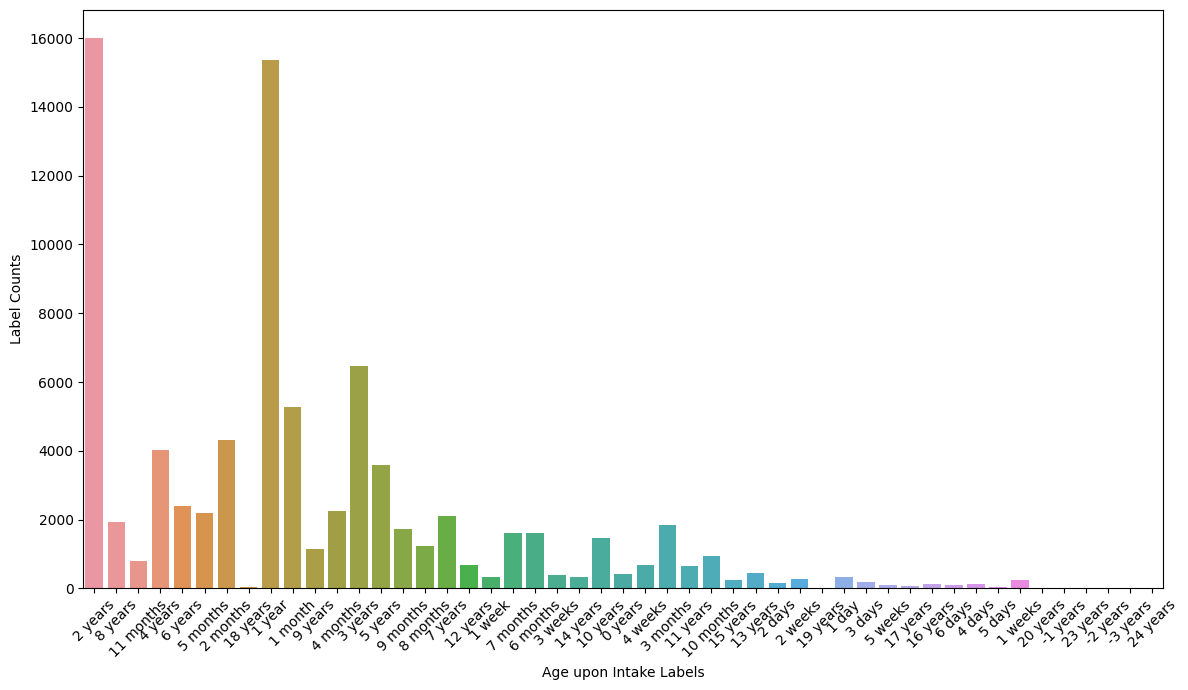

In [15]:
# Visualize data 
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_intake_df, x = 'Age upon Intake')
plt.xlabel('Age upon Intake Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Data has negative values
- Data has different denominations of time (Years, Months, Weeks, Days)

In [16]:
def age_in_months(age):
    if "year" in age:
        return float(age.split()[0]) * 12
    elif "month" in age:
        return float(age.split()[0])
    elif "week" in age:
        return float(age.split()[0]) / 4
    elif "day" in age:
        return float(age.split()[0]) / 30
    else:
        return 99999.9
    
# Remove NULL Records
dog_intake_df = dog_intake_df[dog_intake_df['Age upon Intake'].notnull()]
# Remove Negative Values from the dataset
dog_intake_df = dog_intake_df[~dog_intake_df['Age upon Intake'].str.contains("-")]
# convert Age upon Intake Labels into months
dog_intake_df['age_intake_months'] = dog_intake_df['Age upon Intake'].apply(age_in_months)

<Figure size 1200x700 with 0 Axes>

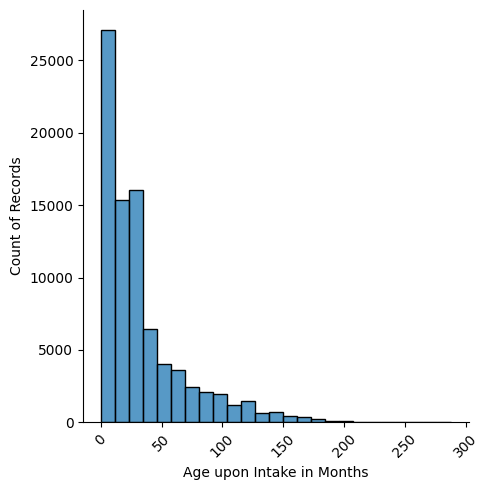

In [17]:
# Show distribution of new field
plt.figure(figsize=(12,7))
sns.displot(data=dog_intake_df, x = 'age_intake_months', bins = 25)
plt.xlabel('Age upon Intake in Months')
plt.ylabel('Count of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intake Type

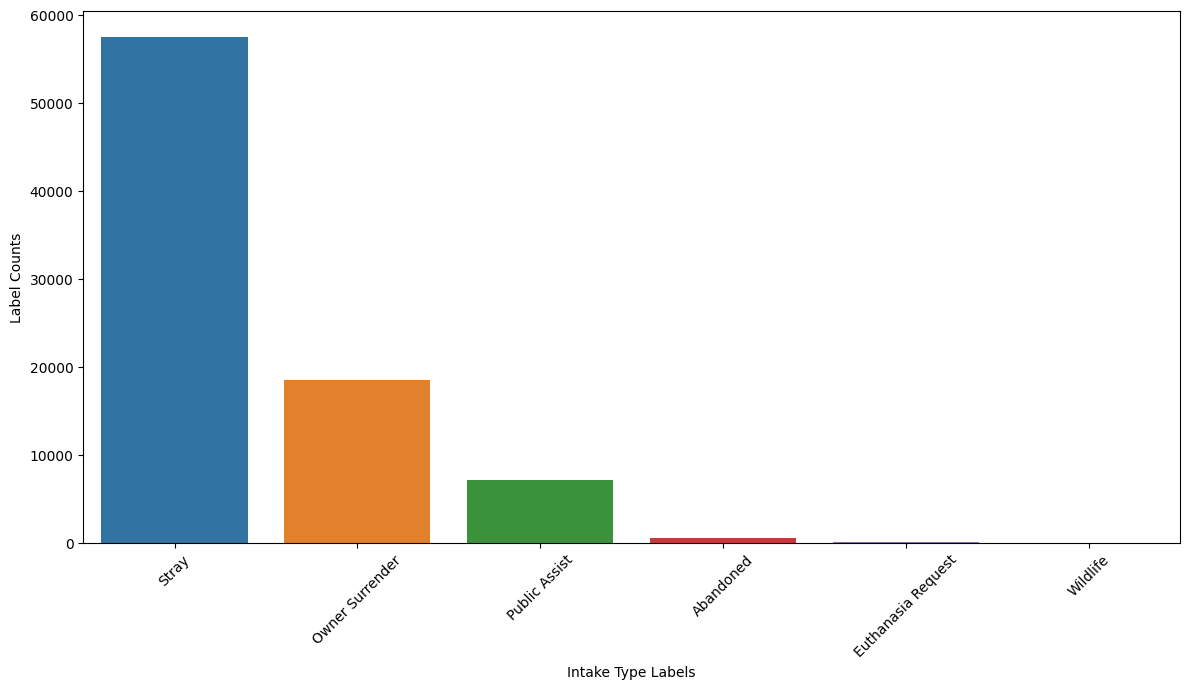

In [18]:
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_intake_df, x = 'Intake Type')
plt.xlabel('Intake Type Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- No Null value or odd results
- Create Dummy Values for use in future machine learning

In [19]:
# Create Dummy Variables for intake type
dog_intake_df = pd.get_dummies(dog_intake_df, columns=['Intake Type']) 
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,weight_low_lbs,weight_high_lbs,weight_median_lbs,age_intake_months,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,18,30,24.0,24.0,0,0,0,0,1,0
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,45,55,50.0,96.0,0,0,0,0,1,0
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,20,22,21.0,11.0,0,0,0,0,1,0
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,60,100,80.0,48.0,0,0,0,0,1,0
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,55,80,67.5,24.0,0,0,1,0,0,0


## Intake Condition

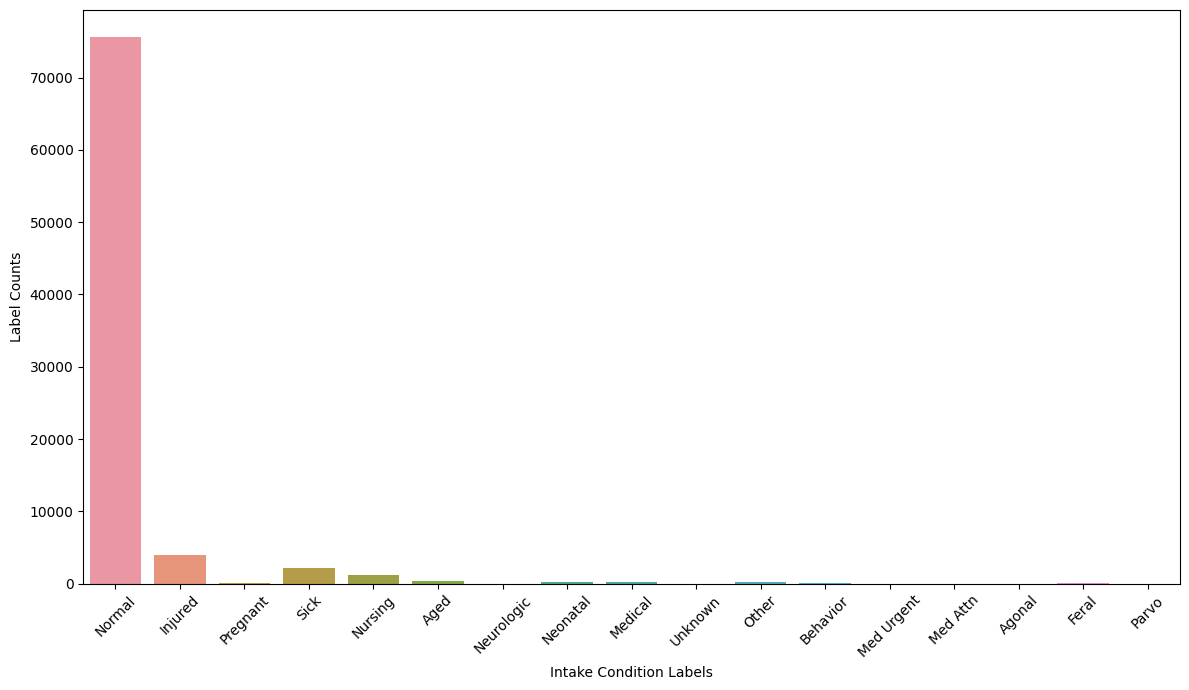

In [20]:
# Visualize data
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_intake_df, x = 'Intake Condition')
plt.xlabel('Intake Condition Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
norm_int_con_perc = (len(dog_intake_df[dog_intake_df['Intake Condition'] == 'Normal']) / len(dog_intake_df)) * 100
from IPython.display import Markdown, display
display(Markdown(f""" 
- Normal records account for {round(norm_int_con_perc, 2)} percent of the records
- Unknown/Other counts for a small amount of the data no plans to remove
- Will create a normal flag
"""))

 
- Normal records account for 89.77 percent of the records
- Unknown/Other counts for a small amount of the data no plans to remove
- Will create a normal flag


In [22]:
# flags whether the dog was in normal condition at intake
dog_intake_df['Intake Condition_Normal'] = np.where(dog_intake_df['Intake Condition'] == 'Normal', 1, 0)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,weight_high_lbs,weight_median_lbs,age_intake_months,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,30,24.0,24.0,0,0,0,0,1,0,1
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,55,50.0,96.0,0,0,0,0,1,0,1
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,22,21.0,11.0,0,0,0,0,1,0,1
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,100,80.0,48.0,0,0,0,0,1,0,1
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,80,67.5,24.0,0,0,1,0,0,0,1


## Sex upon Intake

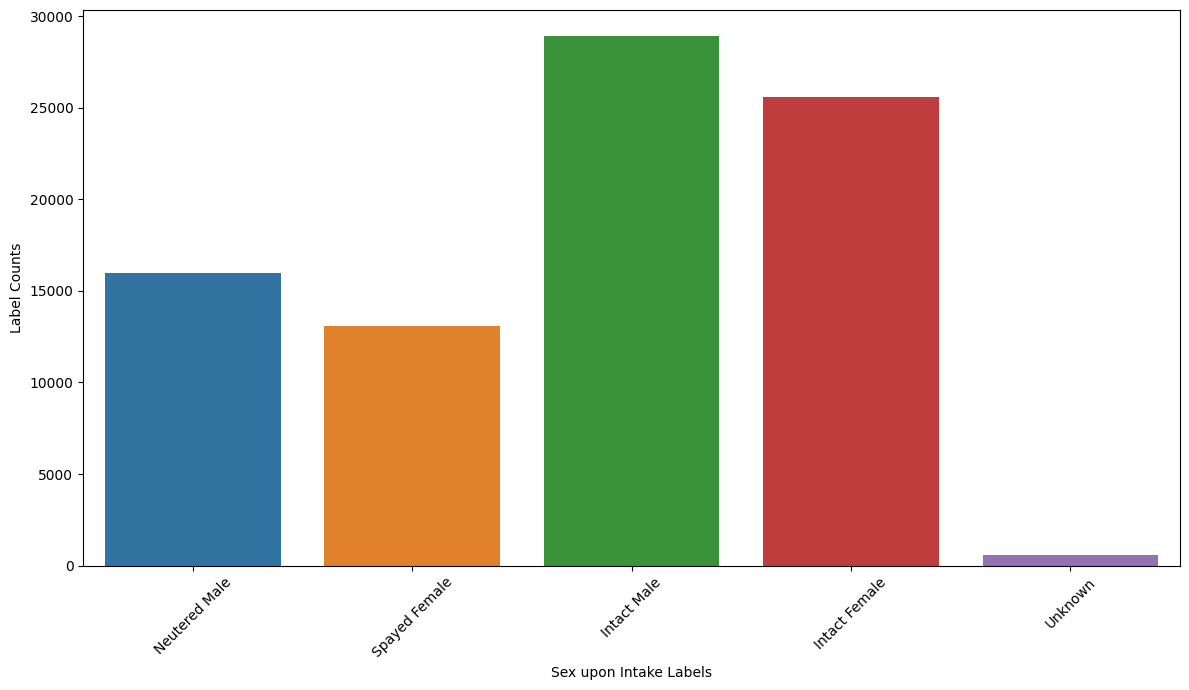

In [23]:
# Visualize data
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_intake_df, x = 'Sex upon Intake')
plt.xlabel('Sex upon Intake Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
unknown_sex_perc = (len(dog_intake_df[dog_intake_df['Sex upon Intake'] == 'Unknown']) / len(dog_intake_df)) * 100
from IPython.display import Markdown, display
display(Markdown(f""" 
- Unknown records account for {round(unknown_sex_perc, 2)} percent of the records
- Will create a flag indicating if they are fixed 
- Will create a flag indicating if they are male
"""))

 
- Unknown records account for 0.71 percent of the records
- Will create a flag indicating if they are fixed 
- Will create a flag indicating if they are male


In [25]:
def fix_flg(sex):
    if sex in ['Neutered Male','Spayed Female']:
        return 1
    else:
        return 0
# Remove NULL Records from the Sex upon Intake column
dog_intake_df = dog_intake_df[dog_intake_df['Sex upon Intake'].notnull()]
# Creates a flag that determines whether the dog was spayed/neutered
dog_intake_df['fix_flg'] = dog_intake_df['Sex upon Intake'].apply(fix_flg)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,weight_median_lbs,age_intake_months,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal,fix_flg
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,24.0,24.0,0,0,0,0,1,0,1,1
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,50.0,96.0,0,0,0,0,1,0,1,1
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,21.0,11.0,0,0,0,0,1,0,1,0
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,80.0,48.0,0,0,0,0,1,0,1,1
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,67.5,24.0,0,0,1,0,0,0,1,1


In [26]:
# break out a flag if the dog is identified as male
def male_flg(sex):
    if sex in ['Neutered Male','Intact Male']:
        return 1
    else:
        return 0
dog_intake_df['male_flg'] = dog_intake_df['Sex upon Intake'].apply(male_flg)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,age_intake_months,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal,fix_flg,male_flg
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,24.0,0,0,0,0,1,0,1,1,1
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,96.0,0,0,0,0,1,0,1,1,0
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,11.0,0,0,0,0,1,0,1,0,1
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,48.0,0,0,0,0,1,0,1,1,1
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,24.0,0,0,1,0,0,0,1,1,1


## Breed

In [27]:
# Adds a flag that determines whether or not the dog is of mixed breed
def mix_flg(breed):
    if "mix" in breed.lower():    
        return 1
    elif "/" in breed:
        return 1
    else:
        return 0
dog_intake_df['mix_flg'] = dog_intake_df['Breed'].apply(mix_flg)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal,fix_flg,male_flg,mix_flg
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,0,0,0,0,1,0,1,1,1,1
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,0,0,0,0,1,0,1,1,0,0
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,0,0,0,0,1,0,1,0,1,1
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,0,0,0,0,1,0,1,1,1,1
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,0,0,1,0,0,0,1,1,1,1


## Color

In [28]:
# break out black dogs into its own flag where black was the only color recorded
dog_intake_df['Color_Black'] = np.where(dog_intake_df['Color'] == 'Black', 1, 0)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal,fix_flg,male_flg,mix_flg,Color_Black
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,0,0,0,1,0,1,1,1,1,0
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,0,0,0,1,0,1,1,0,0,0
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,0,0,0,1,0,1,0,1,1,0
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,0,0,0,1,0,1,1,1,1,0
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,0,1,0,0,0,1,1,1,1,0


In [29]:
# Adds a flag if the dog has any black color recorded.
dog_intake_df['Color_Any_Black'] = np.where(dog_intake_df['Color'].str.contains('Black'), 1, 0)
dog_intake_df.head(5)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,...,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Normal,fix_flg,male_flg,mix_flg,Color_Black,Color_Any_Black
0,A786884,*Brock,2019-01-03 16:19:00,2019-01-01,2501 Magin Meadow Dr in Austin (TX),Normal,Dog,Neutered Male,2 years,Beagle Mix,...,0,0,1,0,1,1,1,1,0,0
1,A706918,Belle,2015-07-05 12:59:00,2015-07-01,9409 Bluegrass Dr in Austin (TX),Normal,Dog,Spayed Female,8 years,English Springer Spaniel,...,0,0,1,0,1,1,0,0,0,0
2,A724273,Runster,2016-04-14 18:43:00,2016-04-01,2818 Palomino Trail in Austin (TX),Normal,Dog,Intact Male,11 months,Basenji Mix,...,0,0,1,0,1,0,1,1,0,0
3,A682524,Rio,2014-06-29 10:38:00,2014-06-01,800 Grove Blvd in Austin (TX),Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,...,0,0,1,0,1,1,1,1,0,0
4,A743852,Odin,2017-02-18 12:46:00,2017-02-01,Austin (TX),Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,...,1,0,0,0,1,1,1,1,0,0


In [30]:
# double check nulls
dog_intake_df.isnull().sum()

Animal ID                             0
Name                              13375
DateTime                              0
MonthYear                             0
Found Location                        0
Intake Condition                      0
Animal Type                           0
Sex upon Intake                       0
Age upon Intake                       0
Breed                                 0
Color                                 0
Breed_join                            0
Breed_primary                         0
height_low_inches                     0
height_high_inches                    0
weight_low_lbs                        0
weight_high_lbs                       0
weight_median_lbs                     0
age_intake_months                     0
Intake Type_Abandoned                 0
Intake Type_Euthanasia Request        0
Intake Type_Owner Surrender           0
Intake Type_Public Assist             0
Intake Type_Stray                     0
Intake Type_Wildlife                  0


In [32]:
dog_intake_df.to_csv('dog_intake_clean_df.csv', index=False)